In [1]:
%cd /content/drive/MyDrive/DataAnalysis/書籍/study_BERT/mycode

/content/drive/MyDrive/DataAnalysis/書籍/study_BERT/mycode


In [2]:
!mkdir ch10

In [2]:
%cd ./ch10

/content/drive/MyDrive/DataAnalysis/書籍/study_BERT/mycode/ch10


In [4]:
!pip install transformers==4.5.0 fugashi==1.1.0 ipadic==1.0.0

     |████████████████████████████████| 2.1 MB 5.4 MB/s 
     |████████████████████████████████| 486 kB 45.7 MB/s 
     |████████████████████████████████| 13.4 MB 27.9 MB/s 
     |████████████████████████████████| 895 kB 43.5 MB/s 
     |████████████████████████████████| 3.3 MB 30.2 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=e175ccb3e04872b07473adb5317b2856467ff4682ded5882ab1e2c3b7a0045f8
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic


In [5]:
import random
import glob
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel

MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

In [6]:
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz 
#ファイルの解凍
!tar -zxf ldcc-20140209.tar.gz

--2022-04-10 07:47:55--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  2.39MB/s    in 3.5s    

2022-04-10 07:47:59 (2.39 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]



In [6]:
# BERTの出力を平均化することで文章ベクトルを生成する
# カテゴリーのリスト
category_list = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]

tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model= BertModel.from_pretrained(MODEL_NAME)
model = model.cuda()

# 各データ形式を整える
max_length = 256
sentence_vectors = []
labels = []
for label, category in enumerate(tqdm(category_list)):
    for file in glob.glob(f'./text/{category}/{category}*'):
        lines = open(file).read().splitlines()
        text = '\n'.join(lines[3:])
        encoding = tokenizer(text, max_length = max_length, padding = 'max_length', truncation = True, return_tensors = 'pt')
        encoding = {k: v.cuda() for k, v in encoding.items()}
        attention_mask = encoding['attention_mask']

        # 文章ベクトルを計算
        with torch.no_grad():
            output = model(**encoding)
            last_hidden_state = output.last_hidden_state
            averaged_hidden_state = (last_hidden_state*attention_mask.unsqueeze(-1)).sum(1)/attention_mask.sum(1, keepdim = True)

        # 文章ベクトルとラベルを追加
        sentence_vectors.append(averaged_hidden_state[0].cpu().numpy())
        labels.append(label)

sentence_vectors = np.vstack(sentence_vectors)
labels = np.array(labels)

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

100%|██████████| 9/9 [05:00<00:00, 33.43s/it]


In [7]:
# 文書数, hidden_size
sentence_vectors.shape

(4906, 768)

# ベクトルの可視化

In [8]:
sentence_vectors_pca = PCA(n_components = 2).fit_transform(sentence_vectors)
print(sentence_vectors_pca.shape)

(4906, 2)


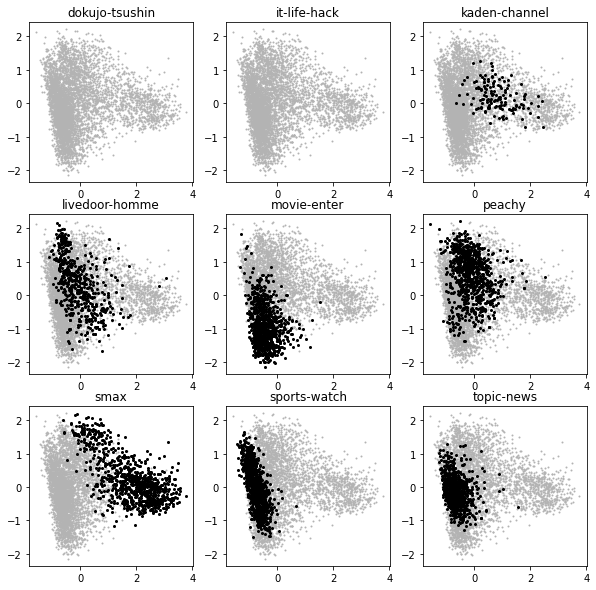

In [9]:
# 10-7
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_pca[:,0], 
        sentence_vectors_pca[:,1], 
        'o', 
        markersize=1, 
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_pca[index,0], 
        sentence_vectors_pca[index,1], 
        'o', 
        markersize=2, 
        color='k'
    )
    plt.title(category_list[label])

In [10]:
sentence_vectors_tsne = TSNE(n_components=2).fit_transform(sentence_vectors) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


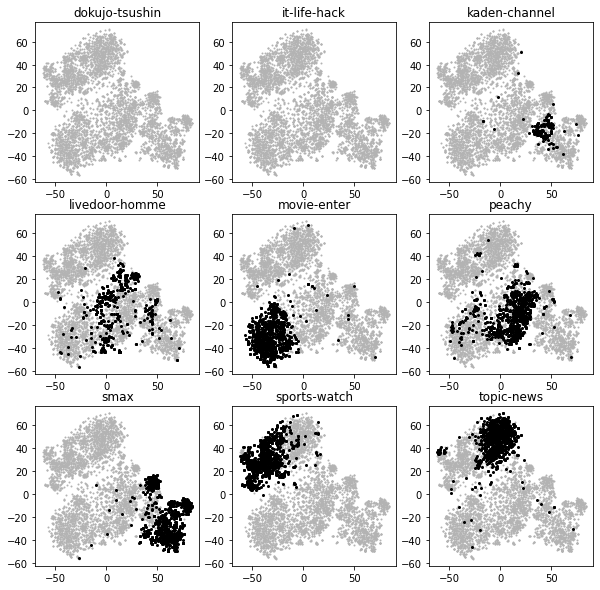

In [11]:
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_tsne[:,0],
        sentence_vectors_tsne[:,1], 
        'o', 
        markersize=1, 
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_tsne[index,0],
        sentence_vectors_tsne[index,1], 
        'o',
        markersize=2,
        color='k'
    )
    plt.title(category_list[label])

In [12]:
# 正規化
norm = np.linalg.norm(sentence_vectors, axis = 1, keepdims = True)
sentence_vectors_normalized = sentence_vectors / norm

# 類似度行列を計算
sim_matrix = sentence_vectors_normalized.dot(sentence_vectors_normalized.T)

# 対角成分は同じ記事なので値を小さくしておく
np.fill_diagonal(sim_matrix, -1)

# 類似度が高い記事のインデックス
similar_news = sim_matrix.argmax(axis = 1)

# 類似文章検索により選ばれた記事とカテゴリが同一であった記事の割合
input_news_categories = labels
output_news_categories = labels[similar_news]
num_correct = (input_news_categories == output_news_categories).sum()
accuracy = num_correct / labels.shape[0]

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89
